# Prediksi Harga Rumah di Ames dengan Machine Learning

Tujuan dari project ini adalah untuk memprediksi harga rumah di Ames, Iowa, Amerika Serikat. Pada notebook ini, akan dilakukan empat tahap:
- Exploratory Data Analysis
- Data wrangling
- Prediksi menggunakan berbagai model machine learning dengan scikit-learn
- Memilih model terbaik dan menggunakannya untuk data test

Dataset berasal dari [Kaggle](https://www.kaggle.com/c/home-data-for-ml-course)

In [1]:
# Mendapatkan library yang dibutuhkan
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Exploratory Data Analysis

In [2]:
# Mendapatkan data training
train_df = pd.read_csv("./data/train.csv")

print(train_df.shape)
# Menampilkan 5 data pertama
train_df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Data terdiri dari 81 kolom dan 1460 baris dengan kolom pertama adalah kolom Id, sehingga ada 80 fitur yang dapat dianalisis 

Mengetahui tipe data tiap kolom & berapa jumlah value yang ada (non-null)

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

- Column object yang mempunyai row null biasanya artinya adalah 'tidak ada' (berdasarkan data_description.txt). Karena itu, semua row dengan null akan diganti dengan string "-".

- Column float64 yang mempunya row null berarti memang data tersebut tidak ada. Ada 3 kolom dengan data float64, yaitu LotFrontage, MasVnrArea, GarageYrBlt. Pendekatan pada LotFrontage akan menggunakan nilai median. MasVnrArea akan di-drop bersama MasVnrType. GarageYrBlt juga di-drop karena ada rumah yang tidak mempunyai garasi.

- Column int64 tidak mempunyai row null.

In [4]:
s = (train_df.dtypes == 'float64')
s = s[s].index
print("Jumlah missing value pada kolom float64:")
print(train_df[s].isna().sum())

Jumlah missing value pada kolom float64:
LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64


### Histogram untuk mengetahui persebaran harga rumah

[]

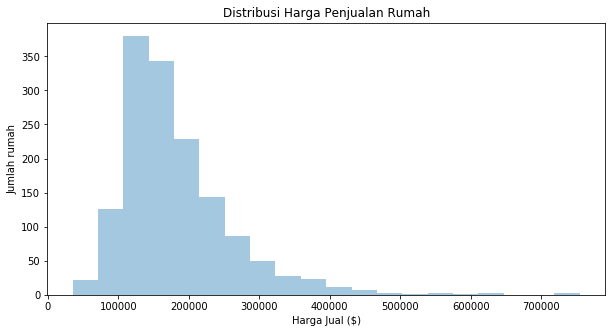

In [5]:
plt.subplots(figsize=(10,5))
sns.distplot(train_df['SalePrice'], kde=False, bins=20)
plt.title("Distribusi Harga Penjualan Rumah")
plt.xlabel("Harga Jual ($)")
plt.ylabel("Jumlah rumah")

plt.plot()

Hasilnya, kebanyakan rumah berada di rentang 100.000 sampai 200.000, tetapi ada sejumlah rumah yang berada pada harga 500.000 maupun sampai 700.000.

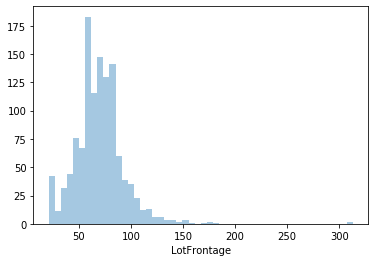

In [6]:
# Mengecek distribusi data lain
sns.distplot(train_df['LotFrontage'], kde=False)

# Data Wrangling

In [7]:
# Menghilangkan sebagian kolom, terutama karena ada data di 
# kolom tersebut yang missing pada test data

dropped_columns = ['Id', 'Neighborhood', 'Exterior1st', 'SaleType',
                   'Exterior2nd', 'MiscFeature', 'MiscVal', 'Fence',
                   'MasVnrType', 'MasVnrArea', 'GarageYrBlt', 'Utilities',
                   'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtUnfSF',
                   'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'Functional',
                   'GarageCars', 'GarageArea']

train_df.drop(columns=dropped_columns, inplace=True)

# Mengganti LotFrontage yang missing menjadi median
train_df['LotFrontage'].fillna(train_df['LotFrontage'].median(), inplace=True)

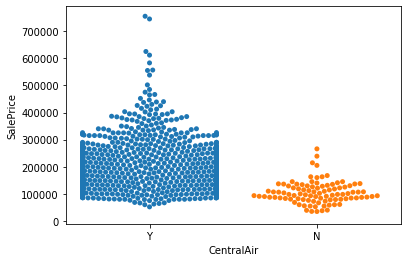

In [8]:
# Relasi antara SalePrice dengan adanya central air conditioning
sns.swarmplot(train_df['CentralAir'], train_df['SalePrice'])

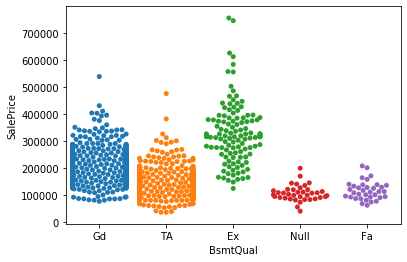

In [9]:
# Relasi 5 tingkat kualitas: Ex, Gd, TA, Fa, np.nan
# dengan harga jual rumah 
sns.swarmplot(train_df['BsmtQual'].fillna("Null"), train_df['SalePrice'])

In [10]:
# Beberapa kolom yang mempunyai 5 atau 6 tingkat kualitas
# akan di mapping dengan pandas
# Ex: Excellent
# Gd: Good
# TA: Average
# Fa: Fair
# Po: Poor
# NaN: tidak ada
quality = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0}
quality_columns = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                     'HeatingQC', 'KitchenQual', 'FireplaceQu',
                     'GarageQual', 'GarageCond', 'PoolQC']

# Mapping kualitas pada kolom di atas menjadi angka
for column in quality_columns:
    train_df[column] = train_df[column].map(quality)

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 59 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Condition1     1460 non-null   object 
 11  Condition2     1460 non-null   object 
 12  BldgType       1460 non-null   object 
 13  HouseStyle     1460 non-null   object 
 14  OverallQual    1460 non-null   int64  
 15  OverallCond    1460 non-null   int64  
 16  YearBuilt      1460 non-null   int64  
 17  YearRemodAdd   1460 non-null   int64  
 18  RoofStyl

In [12]:
from sklearn.preprocessing import OrdinalEncoder


# Membuat daftar kolom yang merupakan objek (categorical)
list_cat = train_df.select_dtypes('O').columns

# Mengisi kolom kosong dengan nilai "-"
train_df.fillna("-", inplace=True)

# Membuat categorical encoding dengan OrdinalEncoder
# dan mengubah categorical data menjadi ordinal data
enc_ord = OrdinalEncoder()
enc_ord.fit(train_df[list_cat])
train_df[list_cat] = enc_ord.transform(train_df[list_cat])

In [13]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MoSold,YrSold,SaleCondition,SalePrice
0,60,3.0,65.0,8450,1.0,0.0,3.0,3.0,4.0,0.0,...,61,0,0,0,0,0,2,2008,4.0,208500
1,20,3.0,80.0,9600,1.0,0.0,3.0,3.0,2.0,0.0,...,0,0,0,0,0,0,5,2007,4.0,181500
2,60,3.0,68.0,11250,1.0,0.0,0.0,3.0,4.0,0.0,...,42,0,0,0,0,0,9,2008,4.0,223500
3,70,3.0,60.0,9550,1.0,0.0,0.0,3.0,0.0,0.0,...,35,272,0,0,0,0,2,2006,0.0,140000
4,60,3.0,84.0,14260,1.0,0.0,0.0,3.0,2.0,0.0,...,84,0,0,0,0,0,12,2008,4.0,250000


### Membuat Heatmap dan Memunculkan 20 Data Pertama

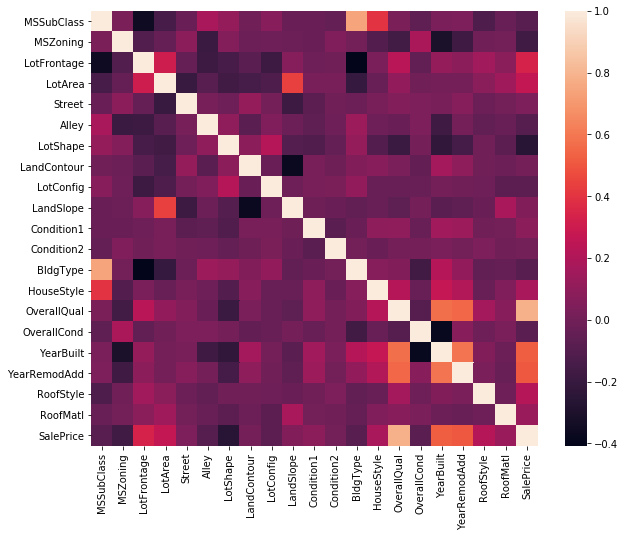

In [14]:
plt.subplots(figsize=(10, 8))
corr_df = pd.concat([train_df.iloc[:,:20], train_df['SalePrice']], axis=1).corr()
sns.heatmap(corr_df)

In [15]:
# Menggunakan MinMaxScaler agar semua data (kecuali SalePrice)
# mempunyai rentang dari 0 sampai 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_columns = train_df.drop(columns='SalePrice').columns
train_df[scaled_columns] = scaler.fit_transform(train_df[scaled_columns])

In [16]:
# Membuang outlier menggunakan stats dari scipy
# dengan cara menghilangkan data dengan z score >= 5
from scipy import stats

z = stats.zscore(train_df)
train_df = train_df[(z < 5).all(axis=1)]
train_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MoSold,YrSold,SaleCondition,SalePrice
0,0.235294,0.75,0.150685,0.033420,1.0,0.0,1.0,1.0,1.0,0.0,...,0.111517,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50,0.8,208500
1,0.000000,0.75,0.202055,0.038795,1.0,0.0,1.0,1.0,0.5,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25,0.8,181500
2,0.235294,0.75,0.160959,0.046507,1.0,0.0,0.0,1.0,1.0,0.0,...,0.076782,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50,0.8,223500
3,0.294118,0.75,0.133562,0.038561,1.0,0.0,0.0,1.0,0.0,0.0,...,0.063985,0.492754,0.0,0.0,0.0,0.0,0.090909,0.00,0.0,140000
4,0.235294,0.75,0.215753,0.060576,1.0,0.0,0.0,1.0,0.5,0.0,...,0.153565,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50,0.8,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,0.000000,0.75,0.236301,0.074398,1.0,0.0,1.0,1.0,1.0,0.0,...,0.102377,0.000000,0.0,0.0,0.0,0.0,0.545455,0.00,0.0,84500
1455,0.235294,0.75,0.140411,0.030929,1.0,0.0,1.0,1.0,1.0,0.0,...,0.073126,0.000000,0.0,0.0,0.0,0.0,0.636364,0.25,0.8,175000
1456,0.000000,0.75,0.219178,0.055505,1.0,0.0,1.0,1.0,1.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.090909,1.00,0.8,210000
1457,0.294118,0.75,0.154110,0.036187,1.0,0.0,1.0,1.0,1.0,0.0,...,0.109689,0.000000,0.0,0.0,0.0,0.0,0.363636,1.00,0.8,266500


# Membuat Model Machine Learning

In [17]:
# Membagi data training dan data test
from sklearn.model_selection import train_test_split

X = train_df.drop(columns=['SalePrice'])
y = train_df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Menggunakan berbagai algoritma regresi untuk mendapatkan skor terbaik
Pada dataset ini, diutamakan untuk mendapatkan mean absolute error (MAE) terendah.

In [18]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

regressors = {'RF': RandomForestRegressor(),
              'DT': DecisionTreeRegressor(),
              'XGB': XGBRegressor(),
              'GB': GradientBoostingRegressor(),
              'Lasso': Lasso()}

for reg_name in regressors:
    cv_result = cross_val_score(
        regressors[reg_name], X_train, y_train,
        cv=5, n_jobs=2, scoring='neg_mean_absolute_error')
    
    print(f"{reg_name}: {round(cv_result.mean())*-1} ({round(cv_result.std())})")

RF: 17095.0 (734.0)
DT: 24957.0 (1008.0)
XGB: 17983.0 (928.0)
GB: 16077.0 (799.0)
Lasso: 19427.0 (1448.0)


GradientBoostingRegressor mendapat skor terkecil. Oleh karena itu, kita akan menggunakan algoritma GradientBoostingRegressor.

In [19]:
# Menggunakan Grid Search agar mendapatkan hasil yang lebih baik
from sklearn.model_selection import GridSearchCV

reg = GradientBoostingRegressor()
params = {'learning_rate': [0.03],
          'n_estimators': [900],
          'min_samples_split': [4],
          'min_samples_leaf': [2],
          'max_depth': [3],
          'max_features': [15],
          'subsample': [0.5]
          }
gscv = GridSearchCV(reg, param_grid=params, scoring='neg_mean_absolute_error', n_jobs=2)
gscv.fit(X_train, y_train)

print(gscv.best_score_)
gscv.best_params_

-15639.640966449257


{'learning_rate': 0.03,
 'max_depth': 3,
 'max_features': 15,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 900,
 'subsample': 0.5}

In [20]:
from sklearn.metrics import mean_absolute_error

reg = GradientBoostingRegressor(learning_rate=0.03, max_depth=3,
                                max_features=15, min_samples_leaf=2,
                                min_samples_split=4, n_estimators=900,
                                subsample=0.5)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mean_absolute_error(y_test, y_pred)

16361.501967811115

# Mengaplikasikan Model ke Data Tes

In [21]:
test_df = pd.read_csv("./data/test.csv")
id_column = test_df["Id"]
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [22]:
# Men-drop kolom
test_df.drop(columns=dropped_columns, inplace=True)

# Mengganti LotFrontage yang missing menjadi median
test_df['LotFrontage'].fillna(train_df['LotFrontage'].median(), inplace=True)

In [23]:
# Mengganti kolom dengan 5/6 kualitas: Ex, Gd, ....
for column in quality_columns:
    test_df[column] = test_df[column].map(quality)

In [24]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 58 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1459 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          107 non-null    object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   LotConfig      1459 non-null   object 
 9   LandSlope      1459 non-null   object 
 10  Condition1     1459 non-null   object 
 11  Condition2     1459 non-null   object 
 12  BldgType       1459 non-null   object 
 13  HouseStyle     1459 non-null   object 
 14  OverallQual    1459 non-null   int64  
 15  OverallCond    1459 non-null   int64  
 16  YearBuilt      1459 non-null   int64  
 17  YearRemodAdd   1459 non-null   int64  
 18  RoofStyl

In [25]:
# Mengganti nilai MSZoning yang missing dengan modus
test_df['MSZoning'] = test_df['MSZoning'].fillna(test_df['MSZoning'].mode()[0])

In [26]:
test_df.fillna("-", inplace=True)

# Label Encoding
test_df[list_cat] = enc_ord.transform(test_df[list_cat])

# MinMaxScaler
test_df[scaled_columns] = scaler.transform(test_df[scaled_columns])

In [27]:
y_prediction = reg.predict(test_df)

In [28]:
# Menyatukan nilai prediction dengan kolom Id
final_df = pd.DataFrame({"Id": id_column.values, "SalePrice": y_prediction})

final_df.to_csv("submission.csv", index=False)

Submission ini mendapatkan skor 15596.88075. Hasil mungkin bisa berubah.